**Импорт библиотек**

In [1]:
import os
import shutil
import json
from PreapreDataLib import create_folder_if_not_exists

import numpy as np
from pycocotools.coco import COCO
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector, show_result_pyplot
import torch

D:\University\miniconda3\envs\RoadDamageDetection\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
DATASET_DIR = './DatasetCocoFormat/'
TRAIN_DIR = DATASET_DIR + 'train/'
TEST_DIR  = DATASET_DIR + 'test/'
VAL_DIR = DATASET_DIR + 'val/'
ANN_DIR = DATASET_DIR + 'annotations/'
TRAIN_ANN_PTH = ANN_DIR + "train.json"
VAL_ANN_PTH = ANN_DIR + "val.json"
TEST_ANN_PTH = ANN_DIR + "test.json"

**Загрузка конфига Mask R-CNN ResNet101 FPN 1x**

In [3]:
CONFIGS_DIR = "./configs/"
create_folder_if_not_exists("./configs/")
MRCNN_BASE_CONFIG_PTH = CONFIGS_DIR + "mask_rcnn_r50_fpn_1x_coco.py"
MRCNN_USER_CONFIG_PTH = CONFIGS_DIR + "mask_rcnn_r50_fpn_1x_coco_for_road_damages_3.py"

In [4]:
if not os.path.exists(MRCNN_BASE_CONFIG_PTH):
    !mim download mmdet --config mask_rcnn_r50_fpn_1x_coco --dest "./configs"

**Изменение конфига под задачу и датасет**

In [5]:
cfg = Config.fromfile(MRCNN_BASE_CONFIG_PTH)

In [6]:
cfg.model.roi_head.bbox_head.num_classes = 2
cfg.model.roi_head.mask_head.num_classes = 2

cfg.data_root = DATASET_DIR

cfg.data.samples_per_gpu = 1
cfg.data.workers_per_gpu = 1

cfg.data.train.img_prefix = TRAIN_DIR
cfg.data.val.img_prefix = VAL_DIR
cfg.data.test.img_prefix = TEST_DIR

cfg.data.train.ann_file = TRAIN_ANN_PTH
cfg.data.val.ann_file = VAL_ANN_PTH
cfg.data.test.ann_file = TEST_ANN_PTH

# (1280, 640)
cfg.test_pipeline[1].img_scale = (640, 320)
cfg.train_pipeline[2].img_scale = (640, 320)

cfg.data.train.pipeline[2].img_scale = (640, 320)
cfg.data.val.pipeline[1].img_scale = (640, 320)
cfg.data.test.pipeline[1].img_scale = (640, 320)

# изменение гиперпараметров
cfg.model.rpn_head.anchor_generator.scales=[4,8,16,32,64]
cfg.model.test_cfg.rcnn.max_per_img = 300
cfg.model.test_cfg.rcnn.nms.iou_threshold = 0.35
# cfg.model.train_cfg.rcnn.mask_size = 56

cfg.optimizer.lr = 0.001
cfg.optimizer.weight_decay = 0.0001
cfg.runner.max_epochs = 20

cfg_classes = ("crack", "pothole")
cfg.data.train.classes = cfg_classes
cfg.data.val.classes = cfg_classes
cfg.data.test.classes = cfg_classes

cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = "cuda"
cfg.load_from = CONFIGS_DIR + "mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth"

cfg.work_dir = CONFIGS_DIR

In [7]:
if os.path.exists(MRCNN_USER_CONFIG_PTH):
    os.remove(MRCNN_USER_CONFIG_PTH)
cfg.dump(MRCNN_USER_CONFIG_PTH)

In [8]:
user_config = Config.fromfile(MRCNN_USER_CONFIG_PTH)
print(user_config.pretty_text)

model = dict(
    type='MaskRCNN',
    backbone=dict(
        type='ResNet',
        depth=50,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        norm_cfg=dict(type='BN', requires_grad=True),
        norm_eval=True,
        style='pytorch',
        init_cfg=dict(type='Pretrained', checkpoint='torchvision://resnet50')),
    neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        num_outs=5),
    rpn_head=dict(
        type='RPNHead',
        in_channels=256,
        feat_channels=256,
        anchor_generator=dict(
            type='AnchorGenerator',
            scales=[4, 8, 16, 32, 64],
            ratios=[0.5, 1.0, 2.0],
            strides=[4, 8, 16, 32, 64]),
        bbox_coder=dict(
            type='DeltaXYWHBBoxCoder',
            target_means=[0.0, 0.0, 0.0, 0.0],
            target_stds=[1.0, 1.0, 1.0, 1.0]),
        loss_cls=dict(
            type='CrossEntropyLoss', use_sigmoid=True, l

**Создание модели**

In [9]:
model = build_detector(user_config.model)

In [10]:
datasets = [build_dataset(cfg.data.train)]

loading annotations into memory...
Done (t=5.10s)
creating index...
index created!


**Обучение модели**

In [11]:
# model.with_cp = True
# model.fp16_enabled = True
train_detector(model, datasets[0], cfg, distributed=False, validate=True)
torch.cuda.empty_cache()

2023-04-26 11:16:07,769 - mmdet - INFO - Automatic scaling of learning rate (LR) has been disabled.


loading annotations into memory...


2023-04-26 11:16:09,574 - mmdet - INFO - load checkpoint from local path: ./configs/mask_rcnn_r50_fpn_1x_coco_20200205-d4b0c5d6.pth


Done (t=1.73s)
creating index...
index created!


2023-04-26 11:16:09,700 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for rpn_head.rpn_cls.weight: copying a param with shape torch.Size([3, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([15, 256, 1, 1]).
size mismatch for rpn_head.rpn_cls.bias: copying a param with shape torch.Size([3]) from checkpoint, the shape in current model is torch.Size([15]).
size mismatch for rpn_head.rpn_reg.weight: copying a param with shape torch.Size([12, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([60, 256, 1, 1]).
size mismatch for rpn_head.rpn_reg.bias: copying a param with shape torch.Size([12]) from checkpoint, the shape in current model is torch.Size([60]).
size mismatch for roi_head.bbox_head.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([3, 1024]).
size mismatch for roi_head.bbox_head.fc_cls.bias: copying a param with shape torch.S

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.96 GiB (GPU 0; 8.00 GiB total capacity; 3.70 GiB already allocated; 2.00 GiB free; 4.40 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [12]:
torch.cuda.empty_cache()

**Сохранение результатов обучения**

In [10]:
MRCNN_RESNET50_FPN_RDD_PTH = CONFIGS_DIR + "mask_rcnn_r50_fpn_1x_coco_for_road_damages_3.pth"
if not os.path.exists(MRCNN_RESNET50_FPN_RDD_PTH):
    shutil.copy(CONFIGS_DIR + "epoch_15.pth", MRCNN_RESNET50_FPN_RDD_PTH)

loading annotations into memory...
Done (t=1.45s)
creating index...
index created!
[1014900  917455  919139 1092531]
load checkpoint from local path: ./configs/mask_rcnn_r50_fpn_1x_coco_for_road_damages_2.pth


D:\University\miniconda3\envs\RoadDamageDetection\lib\site-packages\mmdet\apis\inference.py:51: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '
D:\University\miniconda3\envs\RoadDamageDetection\lib\site-packages\mmdet\datasets\utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


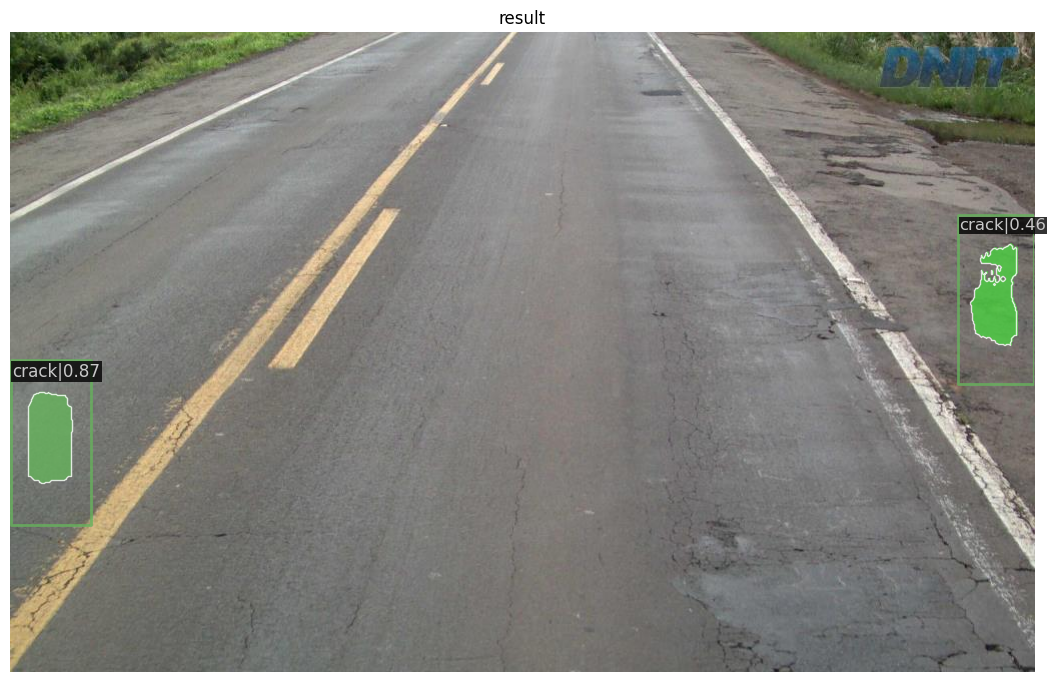

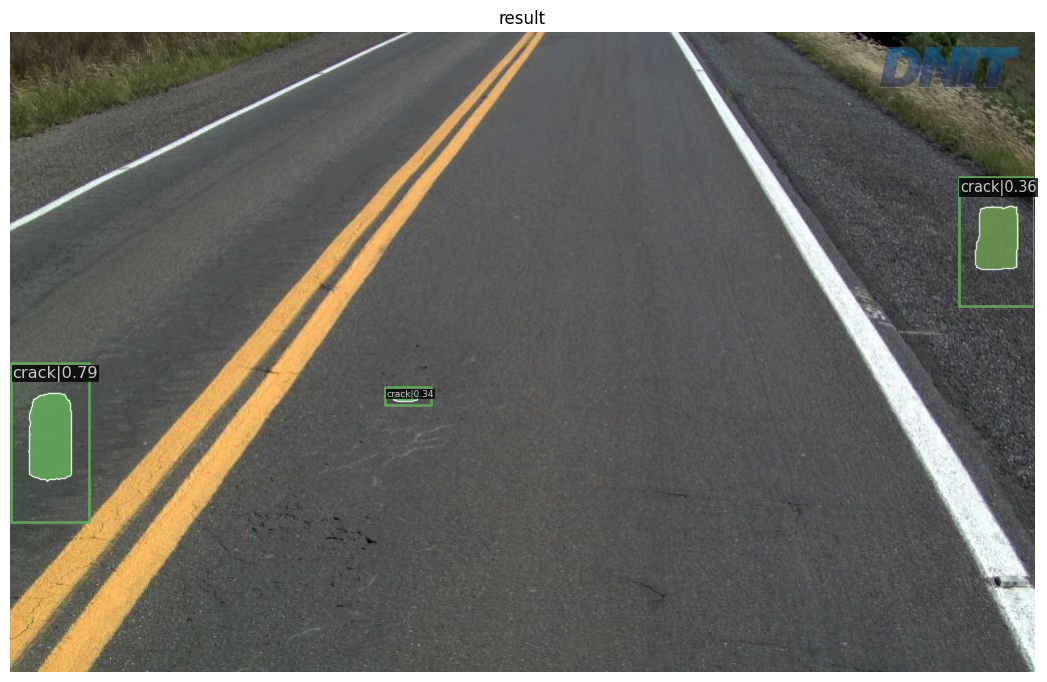

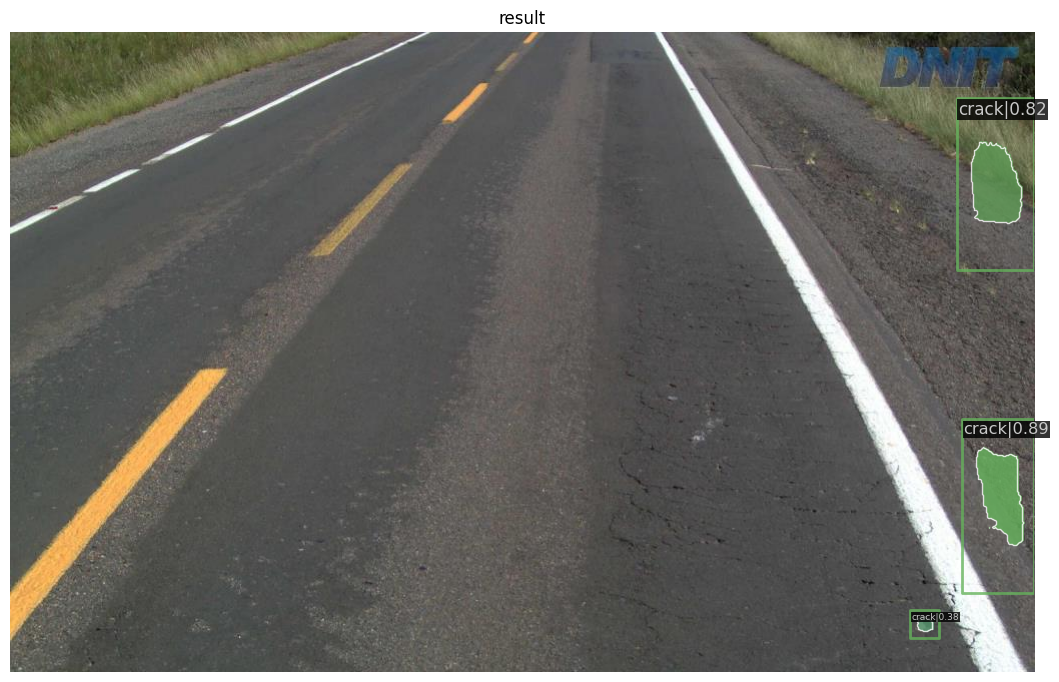

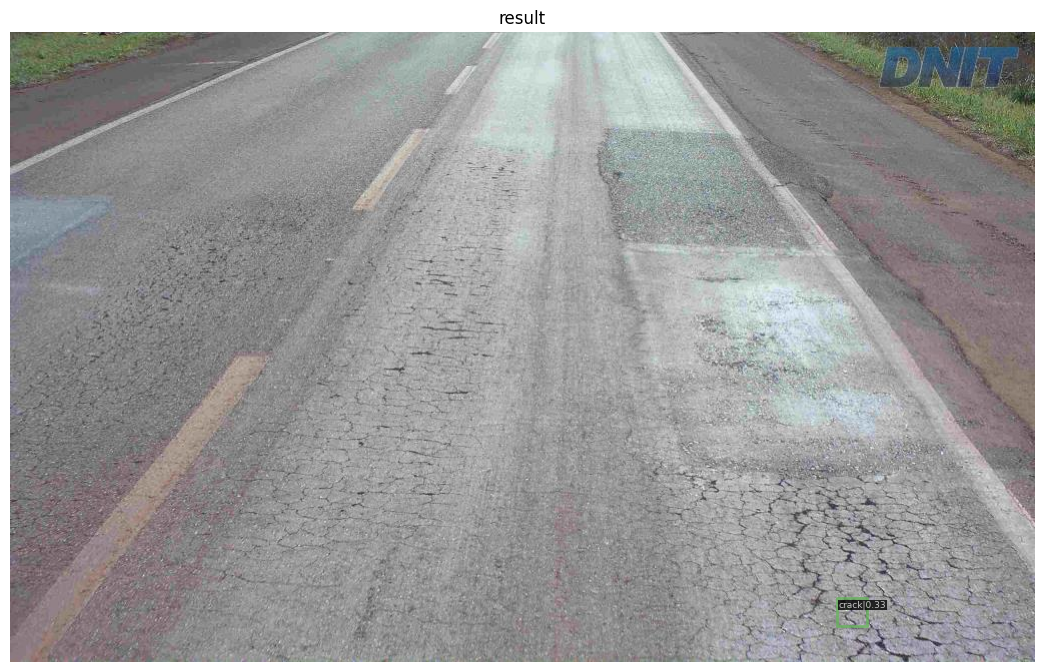

In [11]:
test_coco = COCO(TEST_ANN_PTH)
imgIds = test_coco.getImgIds()
image_ids = np.random.choice(imgIds, 4)
print(image_ids)

testModel = init_detector(MRCNN_USER_CONFIG_PTH, MRCNN_RESNET50_FPN_RDD_PTH, cfg_options=dict(resume_from = MRCNN_RESNET50_FPN_RDD_PTH))
testModel.CLASSES = datasets[0].CLASSES

imgs = test_coco.loadImgs(image_ids)
for img in imgs:
    img_path = TEST_DIR + img['file_name']
    result = inference_detector(testModel, img_path)
    show_result_pyplot(testModel, img_path, result, score_thr=0.3)